# Lab Assignment 2 
## Signature
-----
Alexandre Dufresne-Nappert

20948586

## Tasks
-----

 1. Antiferromagnetic case (J = –1) — Reproduce Figure 10.2 for an antiferromagnet and compare with the
 ferromagnetic case.

 2. Equilibrium analysis — Test if 2000 sweeps are sufficient to reach equilibrium by plotting energy and
 magnetization vs. sweep number at several temperatures.
 
 3. External magnetic field — Modify the model to include a field term (with $g\cdot \mu_B\cdot H = 1$) and study its impact
 on energy, magnetization, heat capacity, and susceptibility.

## Deliverables
-----
Submit a Jupyter Notebook that includes:
- Code (based on Listing 10.1)
- Plots and numerical analysis for each task
- Short discussion of results and physical interpretation


# Imports
-----

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, randint, permutation
from numba import njit

# Function Definitions (From Code Provided)
----
## Notes
-----
I've reorganized the code so that functions are defined at the beginning, I've also optimized the code by having variables passed through by reference instead of using global accesses. 

Most importantly I added the Numba package to make the code compile to C using JIT compilation (Just In Time compilation) so that the code runs as if it is closer to a compiled language granting an overall 120x + speedup (Measured on my PC)

I've also shared this optimized snippet with the rest of the class, but note that I am the original author for this snippet

In [44]:
# Function to change indexes to subscripts ---------------------------------
@njit
def ind2sub(indx, L):
    column = np.floor(indx / L)
    row = indx - column * L
    return row, column

# Metropolis algorithm function --------------------------------------------
@njit
def Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J):
    inverseT = 1/T
    Energy = 0.0
    for counter in range(N):  # for every spin site
        r = int(rowsub[counter])

        lo = r - 1
        if lo < 0:
            lo = L - 1

        hi = r + 1
        if hi > L - 1:
            hi = 0

        c = int(colsub[counter])

        lf = c - 1
        if lf < 0:
            lf = L - 1

        rt = c + 1
        if rt > L - 1:
            rt = 0

        # Sum neighbouring spins
        SS = Spins[lo, c] + Spins[hi, c] + Spins[r, lf] + Spins[r, rt]
        # Energy change if flipped
        DeltaE = 2 * J * SS * Spins[r, c]
        # Metropolis
        if DeltaE < 0 or rand() < np.exp(-DeltaE * inverseT):
            Spins[r, c] = -Spins[r, c]
        if trial >= eqbmstart:
            Energy = Energy - 0.5 * J * SS * Spins[r, c]
    return Energy

@njit
def RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T, L, J):
    M = np.zeros(neq)
    E = np.zeros(neq)

    # Perform Monte-Carlo trials -----------------------------------------------
    for trial in range(trials):
        indx = permutation(N)
        rowsub, colsub = ind2sub(indx, L)
        Energy = Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J)
        if trial >= eqbmstart:
            t = trial - eqbmstart
            E[t] = Energy
            M[t] = np.sum(Spins)
            
    # Results -------------------------------------------------------------------
    Eav = np.mean(E) / N
    Cv = (np.var(E) / T**2) / N
    Mav = np.mean(M) / N
    Chi = (np.var(M) / T) / N
    
    return [Eav, Cv, Mav, Chi]
        

# Plotting Function Definitions
-----


In [45]:
def plotIsingResults(Data, T, title):
    """
    Plot Ising model results (Energy, Specific Heat, Magnetisation, Susceptibility)
    in a 2x2 grid like Figure 10.2.
    Data columns:
        0 - Energy
        1 - Specific Heat
        2 - Magnetisation
        3 - Susceptibility
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.subplots_adjust(hspace=0.35, wspace=0.25)

    # Energy
    axs[0, 0].plot(T, Data[:, 0], 'r--o', linewidth=1.2, markersize=4)
    axs[0, 0].set_xlabel("Temperature")
    axs[0, 0].set_ylabel("Energy")
    axs[0, 0].grid(True)

    # Specific heat
    axs[0, 1].plot(T, Data[:, 1], 'g--o', linewidth=1.2, markersize=4)
    axs[0, 1].set_xlabel("Temperature")
    axs[0, 1].set_ylabel("Specific heat")
    axs[0, 1].grid(True)

    # Magnetisation
    axs[1, 0].plot(T, Data[:, 2], 'b--o', linewidth=1.2, markersize=4)
    axs[1, 0].set_xlabel("Temperature")
    axs[1, 0].set_ylabel("Magnetisation")
    axs[1, 0].grid(True)

    # Susceptibility
    axs[1, 1].plot(T, Data[:, 3], 'm--o', linewidth=1.2, markersize=4)
    axs[1, 1].set_xlabel("Temperature")
    axs[1, 1].set_ylabel("Susceptibility")
    axs[1, 1].grid(True)
    
    fig.suptitle(title, fontsize=18, fontweight='bold')

    plt.show()

def plotEquilibriumAnalysis(DataAntiferro, DataFerro, equilibriation, T, title):
    
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))
    #fig.subplots_adjust(hspace=0.2, wspace=0.1)
    
    for k in range(len(T)):
        # Energy
        axs[k].plot(range(0, equilibriation, 5), DataAntiferro[k, 0, 0:-1:5], '--', linewidth=1, markersize=4, label=f"AntiFerromagnetic")
        axs[k].plot(range(0, equilibriation, 5), DataFerro[k, 0, 0:-1:5], '--', linewidth=1, markersize=4, label=f"Ferromagnetic")
        axs[k].set_xlabel("Equilibriation Steps")
        axs[k].set_ylabel("Energy")
        axs[k].grid(True)
        axs[k].set_title(f"Energy of the System over the course of Equilibriation at T={T[k]}")
        axs[k].legend()
    
    fig.suptitle(f"Energy {title}", fontsize=18, fontweight='bold')

    plt.show()
    
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    
    for k in range(len(T)):
        # Magnetisation
        axs[k].plot(range(0, equilibriation, 5), DataAntiferro[k, 1, 0:-1:5], '--', linewidth=1, markersize=4, label=f"AntiFerromagnetic")
        axs[k].plot(range(0, equilibriation, 5), DataFerro[k, 1, 0:-1:5], '--', linewidth=1, markersize=4, label=f"Ferromagnetic")
        axs[k].set_xlabel("Equilibriation Steps")
        axs[k].set_ylabel("Magnetisation")
        axs[k].grid(True)
        axs[k].set_title(f"Magnetization of the System over the course of Equilibriation at T={T[k]}")
        axs[k].legend()
    fig.suptitle(f"Magnetization {title}", fontsize=18, fontweight='bold')

    plt.show()

# Global Number Variables
------

In [46]:
# Define Number of Points and How many subsims to Average for that point
Points = 10
Averaging = 1

# Question 1 : Antiferromagnetic Simulation
-----
Reproduce the equivalent of Figure 10.2 from the PDF for an antiferromagnetic system ($J=-1$).
Requirements:
- Modify the sign of $J$ in the provided code.
- Run simulations for several temperatures $T$.
- Plot average magnetization $\langle M \rangle$ and energy $\langle E \rangle$ vs. $T$ .
- Compare behavior to the ferromagnetic case ($J=+1$).

In [47]:
def RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, L, J, title):
    # Indexes : 0 : Energy, 1 : Specific Heat Capacity, 2 : Magnetisation, 3 : Spin Susceptiability
    Data = np.empty((Points, 4), dtype=float)

    # Loop through all the Points
    for i in range(Points):
        avgData = np.empty((Averaging, 4), dtype=float)

        # Loop through the number of times to average this location
        for j in range(Averaging):
            Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
            avgData[j] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[i], L, J)

        Data[i] = avgData.mean(axis=0)
    
    plotIsingResults(Data, T, title)

# Define the Magnetic Info and Temperature
SpinSites = 100
N = SpinSites**2  
T = np.linspace(1, 4, Points)  # Temperature

# Simulation Runtime
eqbmstart = 2000  
neq = 1000  
trials = eqbmstart + neq

# Run Antiferromagnetic Simulation
J = -1
#RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Ising Antiferromagnetic (J = -1) Energies, Heat Capacity, Magnetisation and Magnetic Susceptability")

# Run Ferromagnetic Simulation
J = 1
#RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Ising Ferromagnetic (J = 1) Energies, Heat Capacity, Magnetisation and Magnetic Susceptability")

# Question 2 : Equilibrium Analysis
-----
Investigate whether 2000 sweeps are sufficient to reach equilibrium.
 Steps:
 1. Choose temperatures below, near, and above the phase transition (e.g. $T=1.5, 2.3, 3.0$).
 2. Track energy and magnetization as functions of the number of sweeps.
 3. Plot $E$ and $M$ vs. sweeps to see when the system stabilizes.
 4. Comment on whether 2000 sweeps are sufficient



## Modified Function Definition
-----

In [48]:
@njit
def RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T, L, J):
    M = np.zeros(neq)
    E = np.zeros(neq)

    # Perform Monte-Carlo trials -----------------------------------------------
    for trial in range(trials):
        indx = permutation(N)
        rowsub, colsub = ind2sub(indx, L)
        Energy = Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J)
        if trial >= eqbmstart:
            t = trial - eqbmstart
            E[t] = Energy
            M[t] = np.sum(Spins)
            
    # Results -------------------------------------------------------------------
    Eav = E / N
    Mav = M / N
            
    return [Eav, Mav]

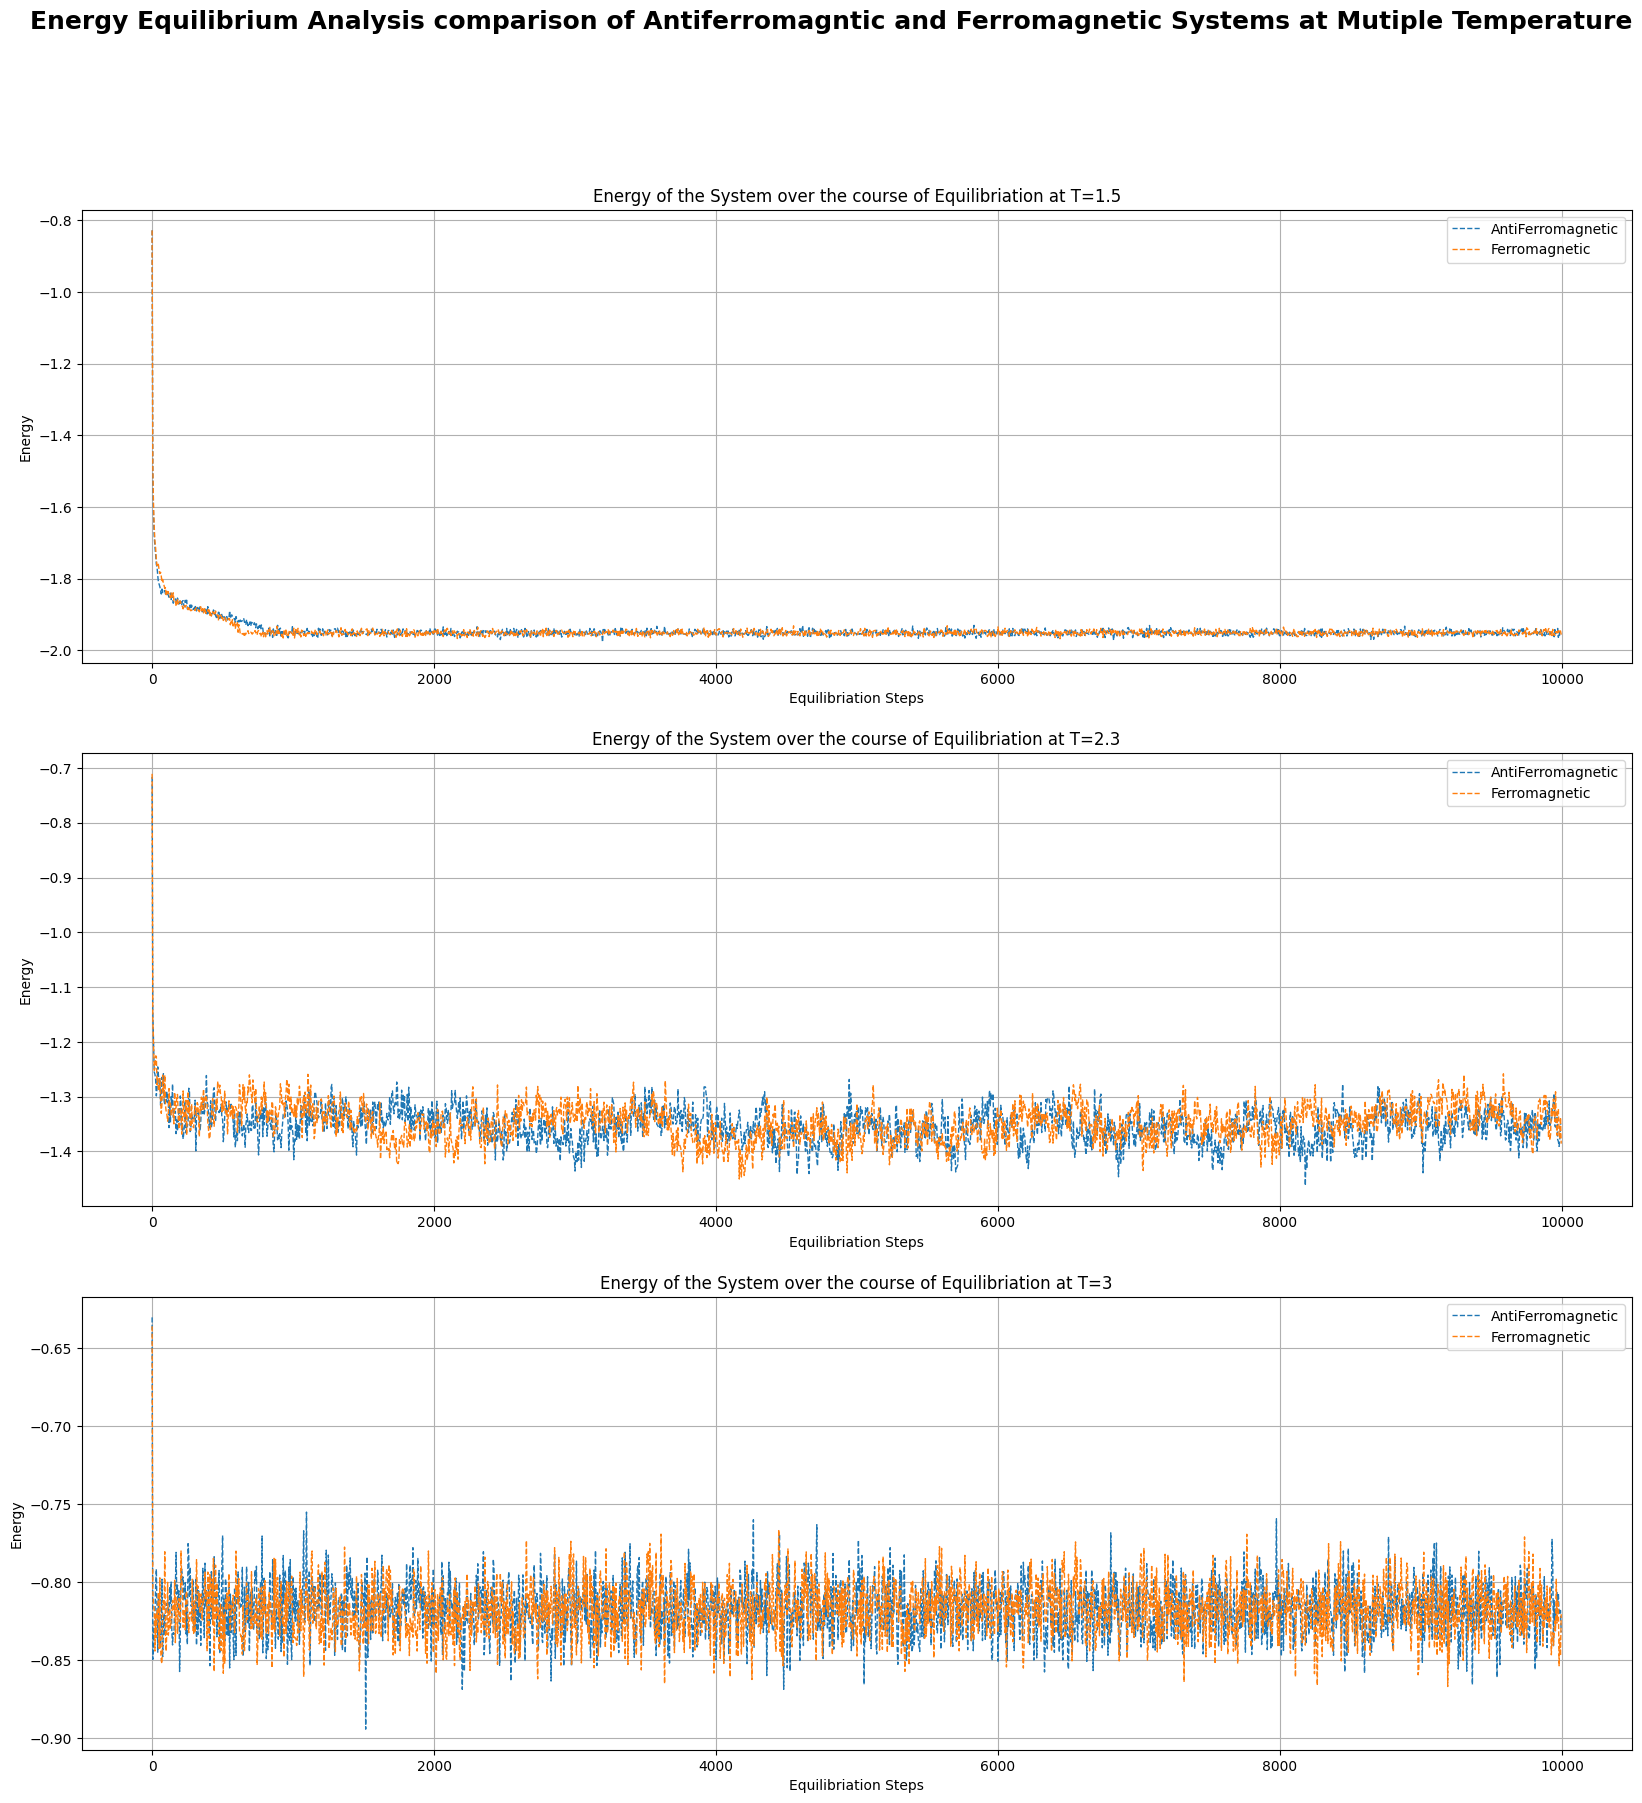

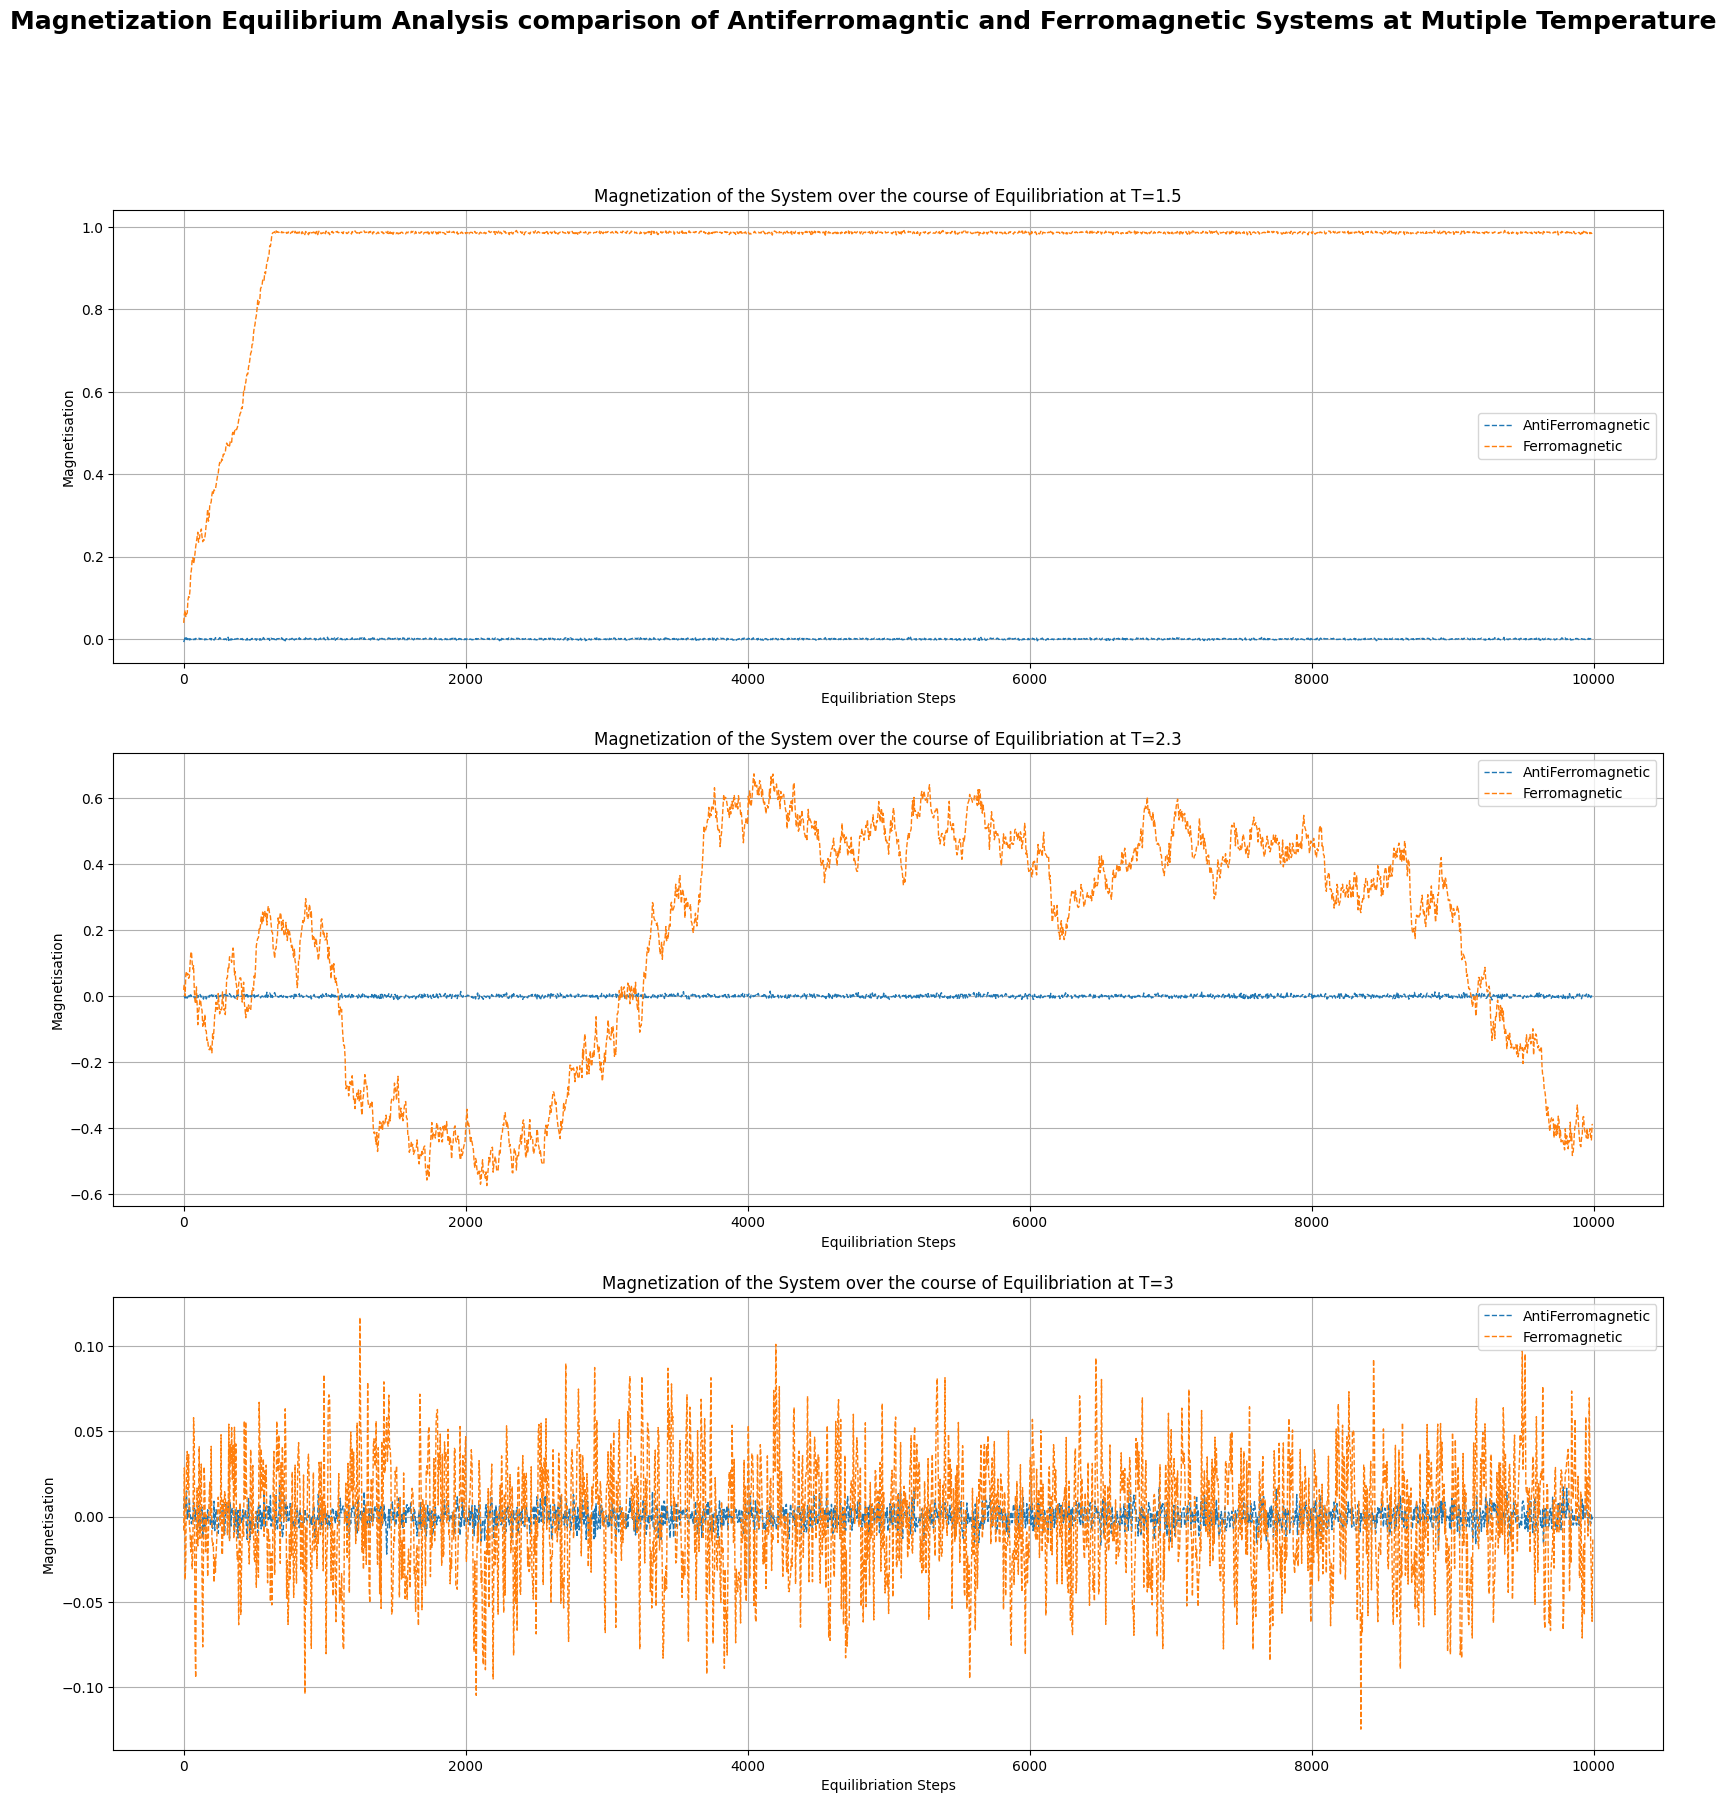

In [49]:
def RunEquilibriumSim(eqbmstart, neq, trials, N, T, L, title):
    # Indexes : 0 : Energy, 1 : Magnetisation
    DataAntiferro = np.empty((len(T), 2, neq), dtype=float)
    DataFerro = np.empty((len(T), 2, neq), dtype=float)

    for k in range(len(T)):
        Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
        DataAntiferro[k] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[k], L, -1)
        
        Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
        DataFerro[k] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[k], L, 1)

    plotEquilibriumAnalysis(DataAntiferro, DataFerro, neq, T, title)

# Define the Magnetic Info and Temperature
SpinSites = 100
N = SpinSites**2  
T = [1.5, 2.3, 3]

# Simulation Runtime  
eqbmstart = 0  
neq = 10000
trials = eqbmstart + neq

# Run Antiferromagnetic Simulation
RunEquilibriumSim(eqbmstart, neq, trials, N, T, SpinSites, "Equilibrium Analysis comparison of Antiferromagntic and Ferromagnetic Systems at Mutiple Temperature")

## Is 2000 Steps enough to converge
-----
Based on the Energy graphs, 2000 steps are enough for the Systems Energy to converge in the both the Ferromagnetic and AntiFerromagnetic regimes

The Magnetization is a little tricker on the other hand. In the case of the AntiFerromagnetic regime, 2000 steps is more than enough for it to converge, but in the case of the FerroMagnetic Regime, it will sometimes converge before 2000 steps, while other times it will fluctuate during the entire simulation. In the case where the system ends up converging, 2000 steps is more than enough. In the case where the magnetization fluctuates during the entire simulation it would not be considered enough. This phenomenon only occurs below the Phase Transition Temperature

Once we reach a high enough temperature the Ferromagnetic regime does end up converging, by fluctuating around 0, but it has a much higher level of noise compared to 



# Question 3 : External Magnetic Field 
-----
Modify the provided code to include a magnetic field term:

$$E=-J\sum_{\langle i, j \rangle} s_i\cdot s_j - g\cdot \mu_B\cdot H \sum_i s_i$$

With $g\cdot \mu_B\cdot H = 1$

Tasks:
- Implement this in your code.
- Run simulations at various temperatures.
- Compute and plot:
    - Energy 
    - Magnetization 
    - Heat capacity 
    - Susceptibility 
- Compare with the zero-field case and discuss the effect of .